## Getting Data

#### The following code query and clean the following data: <ln/>

1) XEM and IOT historical prices

2) Google News search frequency for the phrase "cryptocurrency"- This data should capture turning point events that affect the crytocurrency markets.

3) Subreddit subscription growth- Scraping the site redditmetrics.com to get subreddits “CryptoCurrency”, “Nem”, and “Iota” subscription growth over 3 months period. This data should capture popularity and/or mainstream acceptance. 

4) Google search frequency for the phrases “Nem wallet download”,  “Iota wallet download”, “Nem price”, “Iota price”, “Bitcoin price"- This data should reflect the demand. Original plan was to get the node count (number of wallet in use) or number of wallet software downloaded. However, there was no available API's that provide historical data for this. 

5) AMD and Nvidia stock prices- The top 2 semiconductor companies used for coin mining.

6) Google search frequency for the phrase “GPU for mining”- I expect this data to capture the increased demand for coin mining.

In [2]:
import cryptocompare
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime
from pytrends.request import TrendReq
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import demjson
import eventregistry


# Login to Google
pytrend = TrendReq(hl='en-US', tz=360)
# Get today date
today_date = datetime.datetime.now().strftime('%Y-%m-%d')

In [13]:
# Getting price data of XEM and IOT using Cryptocompare API

# Indicate how many rows of data here
lim = '2000' 
pair = ['XEM', 'IOT']
coins = pd.DataFrame()
# Making API call, normalize JSON file, and put it in Dataframe
for i in pair:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim 
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time') # Set index
    table.index = pd.to_datetime(table.index ,unit='s') # Make datetime object
    coins = pd.concat([coins, table.high], axis=1)
coins.columns = pair

from_date = coins.index[0].strftime('%Y-%m-%d') # Get date where the query started

In [3]:
# Importing market cap data 

mc = pd.read_csv('/Users/gabeheim/documents/repos/bender/source files/mc_coins.csv').set_index('date') # Set index
mc.index = pd.to_datetime(mc.index) # Make datetime object
mc = mc.resample('1h').pad() # Upsample from daily to hourly
type(mc)

pandas.core.frame.DataFrame

In [7]:
# # Query stock data from Yahoo! Financial using pandas_datareader

# # Specify start and end time here
# start = datetime.datetime(2017, 8, 25)
# end = datetime.datetime(2017, 11, 17)

# amd = web.DataReader('AMD', 'yahoo', start, end)
# nvda = web.DataReader('NVDA', 'yahoo', start, end)

# # Cleaning and resampling data
# amd = amd.resample('1h').pad().drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis='columns')
# nvda = nvda.resample('1h').pad().drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis='columns')
# amd.columns = ['amd']
# nvda.columns = ['nvda']

In [24]:
# Getting data from Google Trends using Pytrends API
 
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe=from_date+' '+today_date) # Build payload
ggtrends_1 = pytrend.interest_over_time()
ggtrends_1 = ggtrends_1.resample('1h').pad().drop(['isPartial'], axis='columns') # Upsample daily to hourly
ggtrends_1.columns = ['gg_crypto']

# keyword = 'nem price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['nem price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_2 = pytrend.interest_over_time()
ggtrends_2 = ggtrends_2.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_2.columns = ['gg_nem_p']

# keyword = 'iota price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['iot price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_3 = pytrend.interest_over_time()
ggtrends_3 = ggtrends_3.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_3.columns = ['gg_iota_p']

# keyword = 'bitcoin price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['bitcoin price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_4 = pytrend.interest_over_time()
ggtrends_4 = ggtrends_4.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_4.columns = ['gg_bitcoin_p']

# keyword = 'nem wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['nem wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_5 = pytrend.interest_over_time()
ggtrends_5 = ggtrends_5.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_5.columns = ['gg_nem_w']

# keyword = 'iota wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['iota wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_6 = pytrend.interest_over_time()
ggtrends_6 = ggtrends_6.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_6.columns = ['gg_iota_w']

# keyword = 'gpu mining', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['gpu mining'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_7 = pytrend.interest_over_time()
ggtrends_7 = ggtrends_7.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_7.columns = ['gg_gpu']

In [16]:
# Scraping "CryptoCurrency" subreddit subscription growth data from redditmetrics.com

# Making API call
URL = 'http://www.redditmetrics.com/r/CryptoCurrency'
r = requests.get(URL)

# Scraping the web
json_data = r.text.split('data: ')[1].split('pointSize')[0].strip()[:-1].replace('\n', '') # Locate and grab the data
growth = demjson.decode(json_data) # Decode JSON data to python object
rd_CryptoCurrency_g = pd.DataFrame(growth).set_index('y') # Put data in dataframe format and set index

# Cleaning the data
rd_CryptoCurrency_g = rd_CryptoCurrency_g[~rd_CryptoCurrency_g.index.duplicated(keep='first')] # Get rid of duplicates
rd_CryptoCurrency_g.index = pd.to_datetime(rd_CryptoCurrency_g.index) # Make datetime object
rd_CryptoCurrency_g = rd_CryptoCurrency_g[from_date:]
rd_CryptoCurrency_g = rd_CryptoCurrency_g.resample('1h').pad() # Upsample from daily to hourly
rd_CryptoCurrency_g.columns = ['rd_CrypCurr_g']

#json_data = r.text.split('data: ')[2].split('pointSize')[0].strip()[:-1].replace('\n', '')
#total = demjson.decode(json_data)
#rd_CryptoCurrency_t = pd.DataFrame(total).set_index('y')
#rd_CryptoCurrency_t = rd_CryptoCurrency_t[~rd_CryptoCurrency_t.index.duplicated(keep='first')]
#rd_CryptoCurrency_t.index = pd.to_datetime(rd_CryptoCurrency_t.index)
#rd_CryptoCurrency_t = rd_CryptoCurrency_t[from_date:]
#rd_CryptoCurrency_t = rd_CryptoCurrency_t.resample('1h').pad()
#rd_CryptoCurrency_t.columns = ['rd_CrypCurr_t']


#check if there's duplicates
#import collections
#print([item for item, count in collections.Counter(rd_CryptoCurrency_t.index).items() if count > 1])
#178284- 11/17

In [17]:
# Scraping "nem" subreddit subscription growth data from redditmetrics.com

URL = 'http://www.redditmetrics.com/r/nem'
r = requests.get(URL)

json_data = r.text.split('data: ')[1].split('pointSize')[0].strip()[:-1].replace('\n', '')
growth = demjson.decode(json_data)
rd_nem_g = pd.DataFrame(growth).set_index('y')
rd_nem_g = rd_nem_g[~rd_nem_g.index.duplicated(keep='first')]
rd_nem_g.index = pd.to_datetime(rd_nem_g.index)
rd_nem_g = rd_nem_g[from_date:]
rd_nem_g = rd_nem_g.resample('1h').pad()
rd_nem_g.columns = ['rd_nem_g']

In [18]:
# Scraping "Iota" subreddit subscription growth data from redditmetrics.com

URL = 'http://www.redditmetrics.com/r/Iota'
r = requests.get(URL)

json_data = r.text.split('data: ')[1].split('pointSize')[0].strip()[:-1].replace('\n', '')
growth = demjson.decode(json_data)
rd_Iota_g = pd.DataFrame(growth).set_index('y')
rd_Iota_g = rd_Iota_g[~rd_Iota_g.index.duplicated(keep='first')]
rd_Iota_g.index = pd.to_datetime(rd_Iota_g.index)
rd_Iota_g = rd_Iota_g[from_date:]
rd_Iota_g = rd_Iota_g.resample('1h').pad()
rd_Iota_g.columns = ['rd_Iota_g']

In [23]:
# Joining data frames
df = pd.concat([coins, mc, ggtrends_1, ggtrends_2, ggtrends_3, ggtrends_4, ggtrends_5, ggtrends_6, ggtrends_7, rd_CryptoCurrency_g, rd_nem_g, rd_Iota_g], axis=1).dropna(how='any')
df.to_csv('cap1_df.csv')
df

Empty DataFrame
Columns: [XEM, IOT, mc_iota, mc_nem, gg_crypto, gg_nem_p, gg_iota_p, gg_bitcoin_p, gg_nem_w, gg_iota_w, gg_gpu, rd_CrypCurr_g, rd_nem_g, rd_Iota_g]
Index: []

In [22]:
# Feature Scaling

df_scaled = df.copy(deep=True)
print(df_scaled)
sc_x = StandardScaler()
df_scaled['XEM'] = sc_x.fit_transform(df_scaled['XEM'].values.reshape(-1,1))
df_scaled['IOT'] = sc_x.fit_transform(df_scaled['IOT'].values.reshape(-1,1))
df_scaled['mc_iota'] = sc_x.fit_transform(df_scaled['mc_iota'].values.reshape(-1,1))
df_scaled['mc_nem'] = sc_x.fit_transform(df_scaled['mc_nem'].values.reshape(-1,1))
df_scaled['gg_crypto'] = sc_x.fit_transform(df_scaled['gg_crypto'].values.reshape(-1,1))
df_scaled['gg_nem_p'] = sc_x.fit_transform(df_scaled['gg_nem_p'].values.reshape(-1,1))
df_scaled['gg_iota_p'] = sc_x.fit_transform(df_scaled['gg_iota_p'].values.reshape(-1,1))
df_scaled['gg_bitcoin_p'] = sc_x.fit_transform(df_scaled['gg_bitcoin_p'].values.reshape(-1,1))
df_scaled['gg_nem_w'] = sc_x.fit_transform(df_scaled['gg_nem_w'].values.reshape(-1,1))
df_scaled['gg_iota_w'] = sc_x.fit_transform(df_scaled['gg_iota_w'].values.reshape(-1,1))
df_scaled['gg_gpu'] = sc_x.fit_transform(df_scaled['gg_gpu'].values.reshape(-1,1))
df_scaled['amd'] = sc_x.fit_transform(df_scaled['amd'].values.reshape(-1,1))
df_scaled['nvda'] = sc_x.fit_transform(df_scaled['nvda'].values.reshape(-1,1))
df_scaled['rd_CrypCurr_g'] = sc_x.fit_transform(df_scaled['rd_CrypCurr_g'].values.reshape(-1,1))
df_scaled['rd_nem_g'] = sc_x.fit_transform(df_scaled['rd_nem_g'].values.reshape(-1,1))
df_scaled['rd_Iota_g'] = sc_x.fit_transform(df_scaled['rd_Iota_g'].values.reshape(-1,1))
#df_scaled['rd_CrypCurr_t'] = sc_x.fit_transform(df_scaled['rd_CrypCurr_t'].values.reshape(-1,1))

Empty DataFrame
Columns: [XEM, IOT, mc_iota, mc_nem, gg_crypto, gg_nem_p, gg_iota_p, gg_bitcoin_p, gg_nem_w, gg_iota_w, gg_gpu, rd_CrypCurr_g, rd_nem_g, rd_Iota_g]
Index: []


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

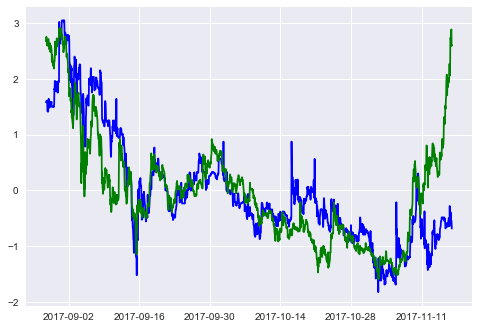

In [11]:
plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
#plt.plot(df_scaled.index, df_scaled['mc_nem'], color='blue')
#plt.plot(df_scaled.index, df_scaled['mc_iota'], color='blue')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_gpu'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['amd'], color='purple')
#plt.plot(df_scaled.index, df_scaled['nvda'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['rd_CrypCurr_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_nem_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_Iota_g'], color='blue')
#plt.xlim(('2017-11-01', '2017-10-10'))
plt.show()

### XEM price- *Blue*
### IOT price- *Green*

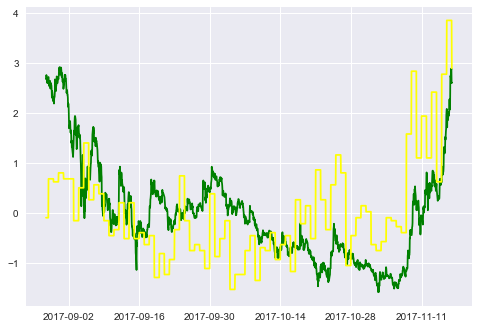

In [12]:
#plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.xlim(('2017-11-01', '2017-10-10'))
plt.show()

### IOT prince- *Green*
### Google search "Iota Wallet"- *Yellow *

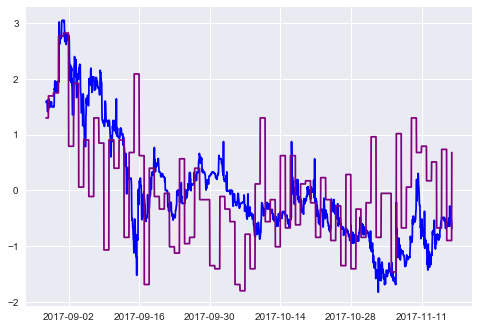

In [13]:
plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
#plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.xlim(('2017-08-28', '2017-10-30'))
plt.show()

### XEM price- *Blue*
### Google search "Nem price"- *Purple*

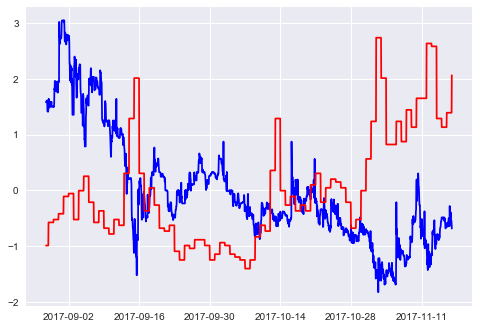

In [14]:
plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
#plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.xlim(('2017-11-01', '2017-10-10'))
plt.show()

### XEM price- *Blue*
### Google search "Bitcoin price"- *Red*

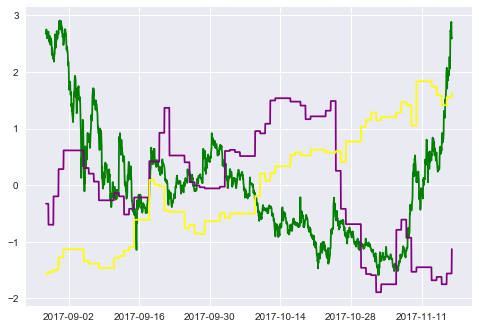

In [15]:
#plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
plt.plot(df_scaled.index, df_scaled['amd'], color='purple')
plt.plot(df_scaled.index, df_scaled['nvda'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.xlim(('2017-11-01', '2017-10-10'))
plt.show()

### IOT price- *Green*
### AMD stock price- *Purple*
### Nvidia stock price- *Yellow*

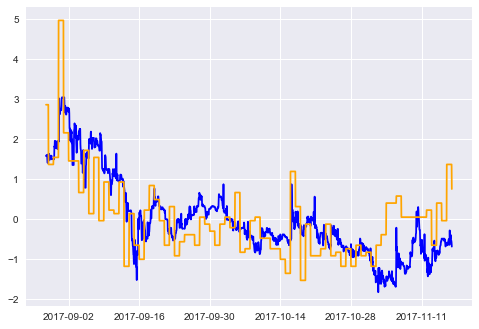

In [16]:
plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
#plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
#plt.plot(df_scaled.index, df_scaled['rd_Iota_g'], color='red')
plt.plot(df_scaled.index, df_scaled['rd_nem_g'], color='orange')
plt.show()

### XEM price- *Blue*
### Subreddit "Nem" subscription growth- *Orange*

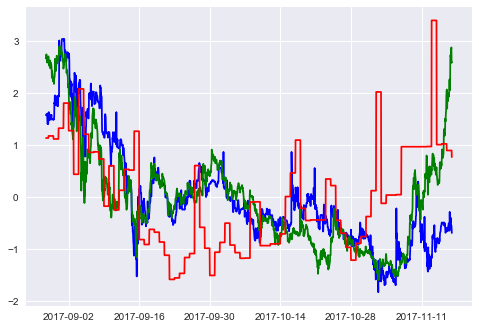

In [17]:
plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
plt.plot(df_scaled.index, df_scaled['rd_CrypCurr_g'], color='red')
plt.show()

### XEM price- *Blue*
### IOT prince- *Green*
### Subreddit "CryptoCurrency" subscription growth- *Red*

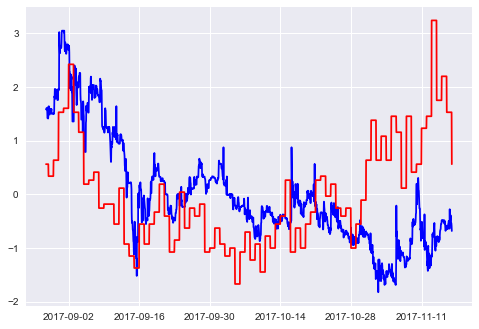

In [18]:
plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
#plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
plt.plot(df_scaled.index, df_scaled['gg_gpu'], color='red')
#plt.plot(df_scaled.index, df_scaled['mc_nem'], color='blue')
#plt.plot(df_scaled.index, df_scaled['mc_iota'], color='blue')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_gpu'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['amd'], color='purple')
#plt.plot(df_scaled.index, df_scaled['nvda'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_CrypCurr_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_nem_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_Iota_g'], color='blue')
plt.show()

### XEM price- *Blue*
### Google search "mining gpu"- *Red*

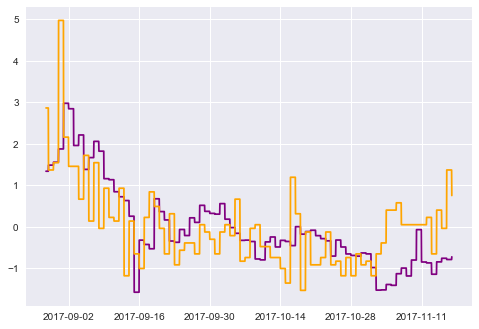

In [19]:
#plt.plot(df_scaled.index, df_scaled['XEM'], color='blue')
#plt.plot(df_scaled.index, df_scaled['IOT'], color='green')
plt.plot(df_scaled.index, df_scaled['mc_nem'], color='purple')
#plt.plot(df_scaled.index, df_scaled['mc_iota'], color='blue')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_gpu'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['amd'], color='purple')
#plt.plot(df_scaled.index, df_scaled['nvda'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['rd_CrypCurr_g'], color='blue')
plt.plot(df_scaled.index, df_scaled['rd_nem_g'], color='orange')
#plt.plot(df_scaled.index, df_scaled['rd_Iota_g'], color='blue')
plt.show()

### XEM market cap- *Purple*
### Subreddit "Nem" subscription growth- *Orange*

In [20]:
#URL_1 = 'https://www.reddit.com/r/python/about.json'
#data_1 = requests.get(URL_1)
#json_data_1 = data_1.json()
#table_1 = json_normalize(json_data_1, 'data')
#json_data_1

In [21]:
#import praw
# Creating reddit instance
#reddit = praw.Reddit(client_id ='F4Qf0i1vJ_XH1w', 
#                     client_secret ='my_secret', 
#                     username ='litalert', password ='my_password', 
#                     user_agent ='cookies')
#subreddit = reddit.subreddit('python')
#hot = subreddit.hot(limit=1)
#for i in hot:
#    print(i)

#submission = reddit.submission(id='39zje0')
#print(dir(reddit))